# Hyper-personalization Through Product Reviews: Exploring New Market Opportunites

A multi-modal approach to generating user recommendations.

## Import Libraries and Define File Paths

In [1]:
import os
import glob
import json
import scipy
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threadpoolctl
from tqdm import tqdm
import warnings
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
from scipy.sparse import coo_matrix
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split
from math import log2 as log
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, KFold
from surprise.model_selection import train_test_split as train_test_split_surprise
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
from unidecode import unidecode
import uuid

warnings.simplefilter(action='ignore', category=FutureWarning)

dir = "../dataset/utility"

if not os.path.exists(dir):
    os.mkdir(dir)

/Users/juliuscrissalinas/anaconda3/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Define Utility Functions and Dataset Generation Functions

In [2]:
def clean_str(x):
    forbidden_chars = [',', '-', '?', '(', ')',
                       '~', '*', '.', '!']
    x = unidecode(x)
    x = '_'.join(x.replace('& ', '').split(' '))
    x = x.lower().strip()
    for c in forbidden_chars:
        x = x.replace(c, '')
    return x

def items_and_reviews_to_dataframe(json_data):
    products = []
    reviews = []
    asins = []
    asin_product_mapping = []
    for product_data in json_data:
        product = {}
        if ('body' not in product_data or 'reviews' not in product_data['body']
            or 'productInformation' not in product_data['body']):
            continue

        reviews_data = product_data['body'].get('reviews', [])
        product_name = product_data['body'].get('name', 'Unknown Product')
        product_data = product_data['body']
        asin = product_data['canonicalUrl'].split('/')[-1].lower()

        if not reviews_data or len(reviews_data) == 0:
            continue
        
        ignore = ['dimensions', 'country_of_origin', 'batteries_included',
                  'weight', 'height', 'size', 'model', 'manufacturer',
                  'specifications', 'voltage', 'volts', '12v', 'climate_pledge',
                  'capacity', 'number_of_items', 'import', 'lxwxh', 'product'
                  'included']

        product['ASIN'] = asin

        if asin not in asins:
            asin_product_mapping.append({
                'ASIN': asin,
                'name': product_name
            })
            asins.append(asin)
        breadcrumbs = product_data.get('breadCrumbs', [])
        for bc in breadcrumbs:
            name = clean_str(bc['name'])
            flag = True
            for ig in ignore:
                if ig in name:
                    flag = False
            if flag and '_' in name:
                name_list = name.split("_")
                for n in name_list:
                    product[n] = 1.0
            elif flag:
                product[name] = 1.0
        
        products.append(product)

        review = {}
        for r in reviews_data:
            review['ASIN'] = asin
            review['ProductName'] = clean_str(product_name)
            reviewer_link = r['reviewerLink'].split('/')[-1].split('.')[-1]
            if len(reviewer_link) < 1:
                reviewer_link = str(uuid.uuid4())
            review['reviewerID'] = r['reviewerName'] + '_' + reviewer_link
            review['price'] = product_data.get('rawPrice', 0)
            reviewRating = re.findall(r'(\d+\.\d+)', r['reviewRating'])
            reviewLocation = r['reviewDate'].split('on')[0].split(' in ')[-1].replace('the ', '')
            reviewDate = re.findall(r'on (.+)$', r['reviewDate'])
            reviewVotes = re.findall(r'(\d+)', r['reviewVotes'])
            review['image'] = product_data.get('mainImage', None)
            
            if reviewRating:
                review['customerReview'] = float(reviewRating[0])
            else:
                review['customerReview'] = np.nan
            if reviewDate:
                review['reviewDate'] = reviewDate[0]
            else:
                review['reviewDate'] = 'Unknown'
            if reviewLocation:
                review['reviewLocation'] = reviewLocation
            else:
                review['reviewLocation'] = 'Unknown'
            if reviewVotes:
                review['reviewVotes'] = reviewVotes[0]
            else:
                review['reviewVotes'] = 0
            reviews.append(review)
            review = {}
    all_reviews_df = pd.DataFrame(reviews)
    all_items_df = pd.DataFrame(products)
    asins_df = pd.DataFrame(asin_product_mapping)
    return all_reviews_df, all_items_df, asins_df

def get_all_json_data():
    base_dir = '../dataset/extracts/amazon'
    all_json_data = []
    for root, dirs, files in os.walk(base_dir):
        for dir in dirs:
            items_path = os.path.join(root, dir, 'items')
            if os.path.exists(items_path):
                json_files = glob.glob(os.path.join(items_path, '*.json'))
                
                for json_file in tqdm(json_files, desc=f'Loading JSON Files in {dir}'):
                    try:
                        with open(json_file, "r") as f:
                            all_json_data.append(json.load(f))
                    except json.JSONDecodeError:
                        print(f"Error loading JSON from file {json_file}: file is empty or not a valid JSON.")
                    except Exception as e:
                        print(f"Unexpected error loading JSON from file {json_file}: {e}")
    return all_json_data

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv", index_col=0)
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")
    asins_df.set_index('ASIN', inplace=True)

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Generate the Dataset and Preprocess

### Fetch all json data

In [3]:
all_json_data = get_all_json_data()
all_reviews_df, all_items_df, asins_df = items_and_reviews_to_dataframe(all_json_data)
all_reviews_df = all_reviews_df.replace(np.nan, '', regex=True)
all_reviews_df.drop_duplicates(keep="first", inplace=True)
all_reviews_df.to_csv(f"{dir}/reviews.csv")
all_items_df.drop_duplicates(keep='first', inplace=True)
all_items_df.fillna(0, inplace=True)
asins_df.to_csv(f"{dir}/asin_product_mapping.csv", index=False)

Loading JSON Files in microwave:   0%|          | 0/226 [00:00<?, ?it/s]

Loading JSON Files in stove: 100%|██████████| 189/189 [00:00<00:00, 5217.14it/s]


Error loading JSON from file ../dataset/extracts/amazon/stove/items/amazon_B07V7JNTLB.json: file is empty or not a valid JSON.


Loading JSON Files in intel amd processor: 100%|██████████| 144/144 [00:00<00:00, 5357.76it/s]


### Preprocess itemset

In [4]:
all_items_df.reset_index(inplace=True)
vc = all_items_df['ASIN'].value_counts()
to_merge = vc.loc[lambda x: x > 1].index.tolist()

all_items_df.set_index('ASIN', inplace=True)
merge_dicts = []
for asin in to_merge:
    merged_row = all_items_df.loc[asin].sum()
    merged_row = merged_row.drop('level_0')
    d = merged_row.to_dict()
    d['ASIN'] = asin
    merge_dicts.append(d)
    all_items_df.drop(asin, inplace=True)
    
merged_df = pd.DataFrame(merge_dicts)
merged_df.set_index('ASIN', inplace=True)
all_items_df = pd.concat([all_items_df, merged_df])
all_items_df.to_csv(f"{dir}/itemset_preprocessed.csv")

### Preprocess userbase

In [5]:
user_ratings_df = all_reviews_df.drop([
    "reviewVotes", "reviewLocation", "reviewDate",
    "ProductName"], axis=1)

groupby_df = user_ratings_df.groupby('reviewerID')
freq = groupby_df.size().reset_index(name='count')
user_ratings_df = pd.merge(user_ratings_df, freq, on='reviewerID', how='left')
user_ratings_df = user_ratings_df.sort_values(['count'], ascending=False)
user_ratings_df = user_ratings_df[user_ratings_df["count"] >= 5]
topn_reviewers = pd.unique(user_ratings_df["reviewerID"])
user_ratings_df.set_index("reviewerID", inplace=True)
user_ratings_df = user_ratings_df.loc[topn_reviewers]
generic_reviewerIDs = user_ratings_df.groupby('reviewerID').count().sort_values('ASIN', ascending=False)[:8].index.tolist()
topn_reviewers = [r for r in topn_reviewers if r not in generic_reviewerIDs]
user_ratings_df = user_ratings_df.loc[topn_reviewers]

rows = []
columns = all_items_df.index.tolist()
columns.append("reviewerID")

for index, data in user_ratings_df.groupby('reviewerID'):
    row = {'reviewerID': index}
    for ind, d in data.iterrows():
        row[d['ASIN']] = d['customerReview']
    rows.append(row)

df_utility = pd.DataFrame(rows, columns=columns)
df_utility.to_csv(f"{dir}/utility_topn.csv")

## Load Dataset

In [6]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


# Define Trainset and Testset

Get top 20 reviewers

In [7]:
non_nan_count = df_utility.notna().sum(axis=1)
df_top_reviewers = df_utility.loc[non_nan_count.sort_values(ascending=False).index].iloc[:20]
top_uids = df_top_reviewers.index.tolist()


In [8]:
df_non_top_reviewers = df_utility.loc[non_nan_count.sort_values(ascending=False).index].iloc[20:]

In [9]:
df_non_top_reviewers

,b085fzxzj5,b000iw9j20,b0c6rc2k82,b09xjd2znd,b07pqt144t,b086jp7fx9,b07jfl43nx,b0c44fvt2q,b0bwjz2fhw,b0c61kbpc8,...,b0cl4gxlgp,b0cpffh4pz,b0ctcy1wtr,b0cghxs3p8,b09n6xj3cl,b0bhzfpqgy,b0867bkglg,b087wp31h9,b0cjv1mjxm,b08gqxnj4y
reviewerID,,,,,,,,,,,,,,,,,,,,,
Jo_AHXFEMW5RPSWLG5ELU3CBSZHBTWQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nelle Renn_AFVKHDD7S4DTJFHS7N5QAMNMMTCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dustin_AHWZKDPFP7DOCROU6EQ2KQYOLLCQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unspoken Yum_AH2JCQEWME2H6ZGCDIRIQWUKHSRQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMM_AG7RA7MI2CAOMN43VI3YQXAFBRXA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Steph_AHGVP2CKUU6UYACQL4X6VELOUVPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ellen Abarr_AHMMO5K6BOLP6TBAFVMMGQXGJ3MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Try all algorithms
We try all algorithms and evaluate the quality of recommendations.
* Neighborhood-based collaborative filtering
    * KNNBasic
    * KNNWithMeans
    * SVD
* Latent-factor based collaborative filtering
    * Alternating Least Squares (ALS)
* Content-based collaborative filtering
    * User profile numeric aggregation with Euclidean distance

## Neighborhood-based Collaborative Filtering

From Surprise

In [10]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(verbose=False), KNNWithMeans(verbose=False), SVD()]

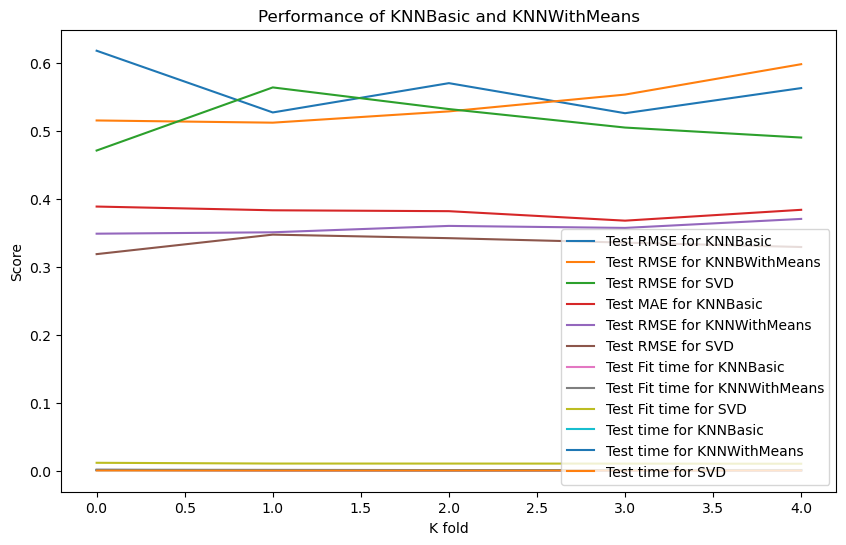

In [11]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)

k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

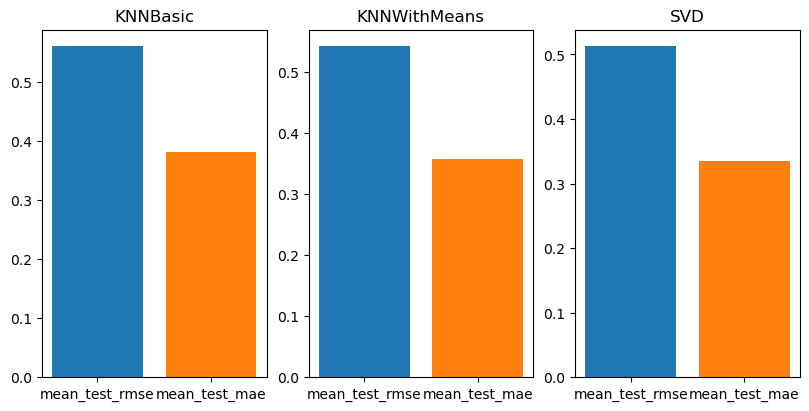

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### NDCG

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py and https://github.com/NicolasHug/Surprise/issues/339

In [13]:
def get_ndcg(surprise_predictions, k_highest_scores=None):
    """ 
    Calculates the ndcg (normalized discounted cumulative gain) from surprise predictions, using sklearn.metrics.ndcg_score and scipy.sparse
  
    Parameters: 
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions
    k_highest_scores (positive integer): Only consider the highest k scores in the ranking. If None, use all. 
  
    Returns: 
    float in [0., 1.]: The averaged NDCG scores over all recommendations
  
    """
    from sklearn.metrics import ndcg_score
    from scipy import sparse
    
    uids = []
    iids = []
    uid_mapping = {}
    iid_mapping = {}

    iter = 0
    for s in surprise_predictions:
        if s.uid in uid_mapping:
            uids.append(uid_mapping[s.uid])
        else:
            uid_mapping[s.uid] = iter
            uids.append(iter)

        if s.iid in iid_mapping:
            iids.append(iid_mapping[s.iid])
        else:
            iid_mapping[s.iid] = iter
            iids.append(iter)

        iter += 1

    r_uis = [p.r_ui for p in surprise_predictions ]
    ests = [p.est for p in surprise_predictions ]
    
    assert(len(uids) == len(iids) == len(r_uis) == len(ests) )    
    
    sparse_preds = sparse.coo_matrix( (ests, (uids , iids )) )
    sparse_vals = sparse.coo_matrix( (r_uis, (uids , iids )) )
    
    dense_preds = sparse_preds.toarray()
    dense_vals = sparse_vals.toarray()
    
    return ndcg_score(y_true= dense_vals , y_score= dense_preds, k=k_highest_scores)

algo_res = {'KNNBasic': {'ndcg': []}, 'KNNWithMeans': {'ndcg': []}, 'SVD': {'ndcg': []}}
method = ["KNNBasic", "KNNWithMeans", "SVD"]
iter = 0
reader = Reader(rating_scale=(0,5))
df_melt_all = (df_utility.reset_index()
                    .melt('reviewerID', var_name='ASIN', value_name='raw_ratings')
                    .dropna())
#trainset = dataset.load_from_df(
#    df_melt_train, reader).build_full_trainset()
trainset = dataset.load_from_df(
    df_melt_all, reader).build_full_trainset()
for algo in algos:
    algo.fit(trainset)
    predictions = algo.test(trainset.build_testset())
    ndcg = get_ndcg(predictions, k_highest_scores=10)
    algo_res[method[iter]]['ndcg'].append(ndcg)
    iter += 1

df_metrics_surprise = pd.DataFrame.from_dict({(i,j): algo_res[i][j] 
                           for i in algo_res.keys() 
                           for j in algo_res[i].keys()},
                       orient='index')
df_metrics_surprise.rename(columns={0: 'NDCG'}, inplace=True)
display(df_metrics_surprise)

,NDCG
"(KNNBasic, ndcg)",0.150956
"(KNNWithMeans, ndcg)",0.150958
"(SVD, ndcg)",0.150928


### Get TopN Recommendations For All Users

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [14]:
def get_random_users(lst, n):
    rand_ids = random.sample(lst, k=n)
    return rand_ids


def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        userids_ilocs.append(original_indices.get_loc(u))
    return userids_ilocs

user_histories = {}
for uid in top_uids:
    user_histories[uid] = reviews_df.loc[uid]['ASIN'].tolist()

userids_ilocs = get_ilocs(df_utility, top_uids)

In [15]:
def get_top_n(predictions, user_history, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if iid not in user_history:
            top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

testset = dataset.load_from_df(
    df_melt_all, reader).build_full_trainset().build_anti_testset()

algo_names = ['KNNBasic', 'KNNWithMeans', 'SVD']
recommendations_surprise = {'KNNBasic': {}, 'KNNWithMeans': {}, 'SVD': {}}
iter = 0
for algo in algos:
    predictions = algo.test(testset)
    for uid in top_uids:
        top_n = get_top_n(predictions, user_histories[uid], n=10)
        for uid, user_ratings in top_n.items():
            if uid in top_uids:
                recommendations_surprise[algo_names[iter]][uid] = [iid for (iid, _) in user_ratings]
                #print(recommendations_surprise[algo_names[iter]][uid])
                #print(user_histories[uid])
                #print('---')
        #break
    iter += 1

## Latent-factor based Collaborative Filtering

### ALS

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

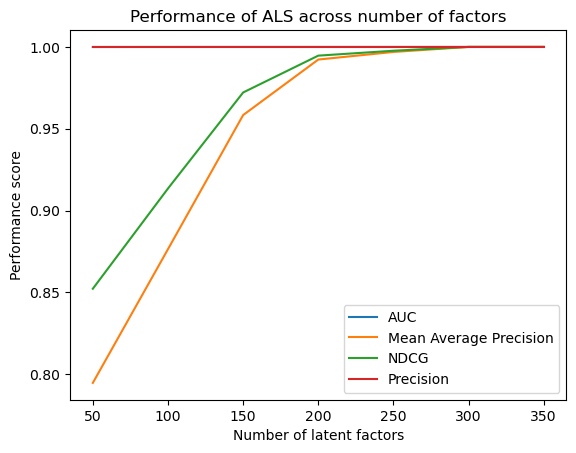

In [16]:
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
#export OPENBLAS_NUM_THREADS=1
threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.05,
        alpha=1.5,
        use_cg=True,
        iterations=20,
        random_state=143
    )
    model.fit(csr_utility, show_progress=False)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)
plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

Select `factors=250`

In [17]:
model = ALS(
    factors=250,
    regularization=0.05,
    alpha=1.5,
    calculate_training_loss=False,
    use_cg=True,
    iterations=20,
    random_state=143
)
model.fit(csr_utility, show_progress=False)

auc = AUC_at_k(model,training_set,test_set,
            K=len(df_utility), show_progress=True)
ndcg_als = ndcg_at_k(model, training_set, test_set,
            K=len(df_utility), show_progress=True)
precision = precision_at_k(model, training_set,
            test_set, K=len(df_utility), show_progress=True)

print(f"AUC: {auc}")
print(f"precision: {precision}")
print(f"ndcg: {ndcg_als}")

ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations_als_ilocs = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]
recommendations_als = {}

for user_ind, reco_ids, scores in recommendations_als_ilocs:
    recos = {}
    reviewer_id = df_utility.iloc[user_ind, :].name
    reco_ids = df_utility.columns[reco_ids]
    n = 0
    for i in range(len(reco_ids)):
        if reco_ids[i] not in user_histories[reviewer_id]:
            recos[reco_ids[i]] = scores[i]
            n += 1
            if n == 9: break
    recommendations_als[reviewer_id]  = recos

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

AUC: 0.999999633081203
precision: 1.0
ndcg: 0.997666707205219


## Content-based Recommender Systems

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

We first use a basic content-based recommender system that relies on aggregating the numeric user profile and various distance metrics such as cosine, euclidean, and jaccard. Then, we compare the results to a Hybrid Recommender System as provided by the LightFM library.

### Content-Based Recommender

* Use numerical user profile aggregation
* Try different distance metrics such as cosine, euclidean, and Jaccard distance

In [18]:
def get_user_profile(user_ratings_nonzero, items_df):
    """
    Return series representing aggregated user profile
    """
    nonzero_asins = user_ratings_nonzero.index.tolist()
    user_profile = items_df.mul(user_ratings_nonzero, axis=0).sum(
        axis=0) / user_ratings_nonzero.notna().sum()
    return user_profile, nonzero_asins


def get_recommendations(user_profile, items_df,
        n, user_history, eval, dist):
    """
    Return dictionary of sorted recommendations
    """
    if dist == 'cos':
        dist_func = distance.cosine
    if dist == 'euc':
        dist_func = distance.euclidean
    if dist == 'jac':
        dist_func = distance.jaccard
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
        if eval:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
    if dist == 'euc':
        rev = False
    if dist == 'cos' or dist == 'jac':
        rev = True
    sorted_similarites = dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=rev)[:n])
    return sorted_similarites


def dcg(user_history, recommendations):
    """
    Return dcg for this user given their history
    and recommendations
    """
    ranking = 1
    dcg_final = 0
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    for key, value in recommendations.items():
        dcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return dcg_final / len(recommendations)


def idcg(user_history, recommendations):
    """
    Return ndcg for this user given their history
    and recommendations
    """
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    ranking = 1
    idcg_final = 0
    for key in actual_ratings.keys():
        idcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return idcg_final / len(recommendations)


def basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, n, eval, dist):
    """
    Return recommendations for the list of users.

    Parameters:
    userids: STRING list
    df_utility: DataFrame representing the utility matrix
    items_df: DataFrame representing the itemset
    reviews_df: DataFrame representing user history
    asins_df: DataFrame that contains mapping between ASINs and Product Names
    n: INTEGER Number of recommendations to output
    dist: STRING distance function to be used
    """
    recommendations = {}
    ndcg = None
    dcg_list = []
    idcg_list = []
    ndcg_list = []
    iter = 0
    for user in userids:
        user_ratings = df_utility.loc[user]
        user_ratings_nonzero = user_ratings[user_ratings > 0]
        user_profile, nonzero_asins = get_user_profile(user_ratings_nonzero, items_df)
        user_history_df = reviews_df.loc[user].drop([
            "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        ], axis=1)
        user_history_df = user_history_df.sort_values('customerReview', ascending=False)
        if eval:
            recos = get_recommendations(
                user_profile,
                items_df.loc[nonzero_asins],
                len(user_profile),
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
            dcg_list.append(dcg(user_history_df, recos))
            idcg_list.append(idcg(user_history_df, recos))
        else:
            recos = get_recommendations(
                user_profile,
                items_df,
                n,
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
        #print(f"sorted user history: {user}")
        #display(user_history_df)
        #print(f"recommended items")
        #df_reco = asins_df.loc[list(recos.keys())]
        #display(df_reco)
        recommendations[user] = recos
        iter += 1
    if eval:
        dcg_final = np.mean(dcg_list)
        idcg_final = np.mean(idcg_list)
        ndcg = dcg_final / idcg_final
        ndcg_list.append(ndcg)
    return recommendations, ndcg_list

## Evaluation: NDCG @ K

Get average NDCG across all users. Compare NDCG across different distance metrics.

In [19]:
np.seterr(invalid='ignore')
ndcg_content = {}
items_df, df_utility, reviews_df, asins_df = load_dataset()
df_utility.fillna(0, inplace=True)
items_df.fillna(0, inplace=True)
recommendations_content = {}
try:
    items_df.drop(['level_0'], inplace=True, axis=1)
except:
    pass
try:
    reviews_df.set_index('reviewerID', inplace=True)
except:
    pass
try:
    asins_df.set_index('ASIN', inplace=True)
except:
    pass

# evaluate ndcg
recommendations, ndcg_list = basic_content_based_recommender(
    top_uids, df_utility, items_df.copy(),
    reviews_df, 10, True, 'euc')
ave_ndcg = np.mean(ndcg_list)
print(f"average ndcg with distance metric euc is {ave_ndcg}")

# generate actual recommendations
recommendations_content['euc'], _ = basic_content_based_recommender(
    top_uids, df_utility, items_df.copy(),
    reviews_df, 10, False, 'euc')

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)
average ndcg with distance metric euc is 0.9698216240443229


## Hybrid Recommender Using LightFM

A hybrid latent representation recommender model.

The model learns embeddings (latent representations in a high-dimensional space) for users and items in a way that encodes user preferences over items. When multiplied together, these representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

### LightFM Training Model

- Logistic: useful when both positive (1) and negative (-1) interactions are present.
- BPR: Bayesian Personalised Ranking 1 pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise 2 loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
- k-OS WARP: k-th order statistic loss 3. A modification of WARP that uses the k-th positive example for any given user as a basis for pairwise updates.

In [20]:
items_df, df_utility, reviews_df, asins_df = load_dataset()
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
udf = melted_user_df

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


In [21]:
dataset = LightFMDataset()
dataset.fit(users=udf['reviewerID'].unique(),
            items=udf['ASIN'].unique())

(interactions, _) = dataset.build_interactions(zip(udf['reviewerID'], 
                                                   udf['ASIN'],
                                                   udf['rating']))

In [22]:
Train, Test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)
model = LightFM(loss='warp', no_components=50)
model.fit(Train, epochs=30, num_threads=1)

In [23]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Train"):
    auc = auc_score(model, Train).mean()
    precision = precision_at_k(model, Train, k=k).mean()
    recall = recall_at_k(model, Train, k=k).mean()

    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Train Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Train: 100%|██████████| 10/10 [00:00<00:00, 18.79it/s]

Train Results:
K = 1: AUC score: 0.9999663829803467, Precision: 0.9973404407501221, Recall: 0.21849170072730778
K = 2: AUC score: 0.9999663829803467, Precision: 0.9920212626457214, Recall: 0.4311323376248283
K = 3: AUC score: 0.9999663829803467, Precision: 0.9796099662780762, Recall: 0.6308467606652838
K = 4: AUC score: 0.9999663829803467, Precision: 0.9434840679168701, Recall: 0.7909778503724059
K = 5: AUC score: 0.9999663829803467, Precision: 0.8686171174049377, Recall: 0.8855333808869479
K = 6: AUC score: 0.9999663829803467, Precision: 0.7819148898124695, Recall: 0.9346101879972342
K = 7: AUC score: 0.9999663829803467, Precision: 0.6979482769966125, Recall: 0.9584346617434855
K = 8: AUC score: 0.9999663829803467, Precision: 0.6256648898124695, Recall: 0.9711925129869435
K = 9: AUC score: 0.9999663829803467, Precision: 0.5653073787689209, Recall: 0.9790639238386422
K = 10: AUC score: 0.9999663829803467, Precision: 0.5159574747085571, Recall: 0.9852486643866494


In [24]:
k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Test"):
    auc = auc_score(model, Test).mean()
    precision = precision_at_k(model, Test, k=k).mean()
    recall = recall_at_k(model, Test, k=k).mean()
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Test Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Test: 100%|██████████| 10/10 [00:00<00:00, 20.80it/s]

Test Results:
K = 1: AUC score: 0.2799954414367676, Precision: 0.0, Recall: 0.0
K = 2: AUC score: 0.2799954414367676, Precision: 0.0017605633474886417, Recall: 0.0011737089201877935
K = 3: AUC score: 0.2799954414367676, Precision: 0.004694835748523474, Recall: 0.00528169014084507
K = 4: AUC score: 0.2799954414367676, Precision: 0.004401408601552248, Recall: 0.007042253521126761
K = 5: AUC score: 0.2799954414367676, Precision: 0.0063380287028849125, Recall: 0.017018779342723004
K = 6: AUC score: 0.2799954414367676, Precision: 0.008215962909162045, Recall: 0.025234741784037555
K = 7: AUC score: 0.2799954414367676, Precision: 0.009557344950735569, Recall: 0.03873239436619718
K = 8: AUC score: 0.2799954414367676, Precision: 0.009242957457900047, Recall: 0.045774647887323945
K = 9: AUC score: 0.2799954414367676, Precision: 0.008998434990644455, Recall: 0.04870892018779342
K = 10: AUC score: 0.2799954414367676, Precision: 0.008450704626739025, Recall: 0.04988262910798121


In [25]:
def dcg_at_k(r, k, method=1):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k, method=1):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def calculate_ndcg(model, dataset, interactions, k=10):
    ndcg_scores = []
    
    for user_id in dataset.mapping()[0].keys():
        try:
            user_index = dataset.mapping()[0][user_id]
            true_items = interactions.tocsr()[user_index].indices
            
            predicted_scores = model.predict(user_index, np.arange(dataset.interactions_shape()[1]))
            sorted_item_indices = np.argsort(-predicted_scores)
            
            r = [1 if i in true_items else 0 for i in sorted_item_indices]
            ndcg_score = ndcg_at_k(r, k)
            ndcg_scores.append(ndcg_score)
        except KeyError:
            continue
    
    return np.mean(ndcg_scores)

k = 10
ndcg_score = calculate_ndcg(model, dataset, Train, k=k)

print(f"NDCG@{k}: {ndcg_score}")

NDCG@10: 0.988124553198101


In [26]:
def get_top_n_recommendations_with_latest_transactions(model, dataset, user_id, transactions_df, user_histories, n=10):
    try:
        transactions_df.reset_index(inplace=True)
    except:
        pass

    # Generate predictions for all items for this user
    user_index = dataset.mapping()[0][user_id]
    
    # Retrieve the actual item indices from the dataset mapping
    item_indices = list(dataset.mapping()[2].values())  # This ensures you're using the correct item indices
    
    # Generate predictions using the correct item indices
    scores = model.predict(user_index, np.array(item_indices))
    
    
    
    # Map scores to item IDs
    reverse_item_map = {v: k for k, v in dataset.mapping()[2].items()}
    scored_items = [(score, reverse_item_map[i]) for score, i in zip(scores, item_indices)]
    
    # Proceed with filtering scores for latest items and ranking them as before
    #latest_transactions = transactions_df[transactions_df['reviewerID'] == user_id]\
    #                        .sort_values('reviewDate', ascending=False)\
    #                        .head(10)
    #latest_items = set(latest_transactions['ASIN'])
    latest_scores = [score for score in scored_items if score[1] not in user_histories[user_id]]
    latest_scores.sort(reverse=True, key=lambda x: x[0])  # Sort based on scores
    top_item_ids = [item for _, item in latest_scores[:n]]

    return top_item_ids

recommendations_lightfm = {}
for uid in top_uids:
    recommendations_lightfm[uid] = get_top_n_recommendations_with_latest_transactions(
        model, dataset, uid, reviews_df, user_histories, n=10)

# Compare NDCG across algorithms

,NDCG
KNNBasic,0.150956
KNNWithMeans,0.150958
SVD,0.150928
ALS,0.997667
Content-based,0.969822
LightFM,0.988125


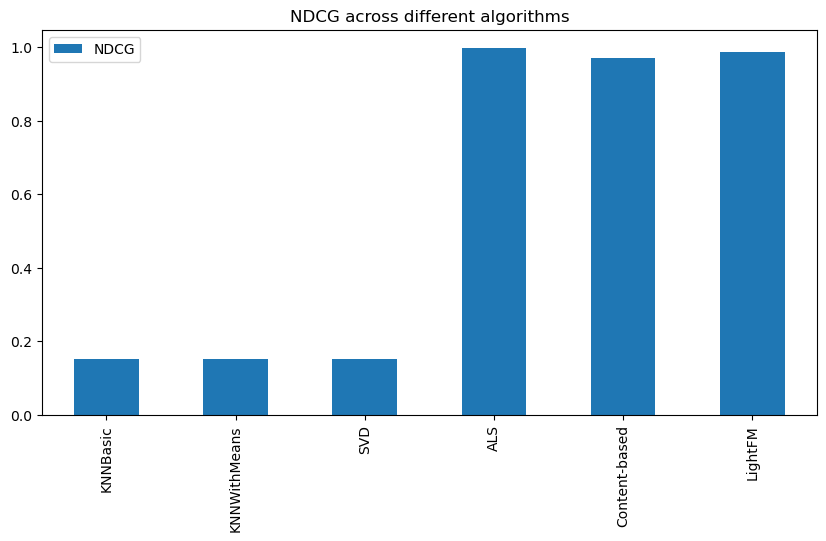

In [27]:
df_surprise_ndcg = df_metrics_surprise.loc[[
    ("KNNBasic", "ndcg"), ("KNNWithMeans", "ndcg"), ("SVD", "ndcg")
    ]]
df_surprise_ndcg.rename(index={
    ("KNNBasic", "ndcg"): "KNNBasic",
    ("KNNWithMeans", "ndcg"): "KNNWithMeans",
    ("SVD", "ndcg"): "SVD"
    }, inplace=True)

ndcg_dict = {
    "KNNBasic": df_surprise_ndcg.loc["KNNBasic"]['NDCG'],
    "KNNWithMeans": df_surprise_ndcg.loc["KNNWithMeans"]['NDCG'],
    "SVD": df_surprise_ndcg.loc["SVD"]['NDCG'],
    "ALS": ndcg_als,
    "Content-based": ave_ndcg,
    "LightFM": ndcg_score
}

ndcg_df = pd.DataFrame.from_dict(ndcg_dict, orient="index")
ndcg_df.rename(columns={0: "NDCG"}, inplace=True)
display(ndcg_df)

ndcg_df.plot(kind='bar', figsize=(10, 5))
plt.title("NDCG across different algorithms")
plt.show()

### Interpretation of Results

- The AUC score is consistently high (0.9986754059791565) across all K values, indicating excellent overall model performance in distinguishing between positive and negative interactions.

- Precision at K measures the proportion of recommended items in the top-K set that are relevant. Precision decreases as K increases in your results, which is expected. When you recommend more items (increase K), the likelihood of including irrelevant items increases, thus lowering precision. However, a precision above 0.08 even at K=10 is quite good, suggesting that the top recommended items are largely relevant.

- Recall at K measures the proportion of relevant items that are successfully recommended in the top-K set. Your results show increasing recall with K, which is typical. As you recommend more items, you're more likely to cover a higher fraction of the relevant items, hence the recall increases. A recall of 0.8549128186215507 at K=10 indicates that about 85% of the relevant items are captured in the top 10 recommendations.

## Sample Recommendations Per Algorithm

In [44]:
try:
    reviews_df.set_index("reviewerID", inplace=True)
except:
    pass
df_list_of_recos = []
uid_recos = {}
pd.set_option('display.max_colwidth', 800)
index = 1
for uid in top_uids:
    user_hist_df = reviews_df.loc[uid][['ASIN', 'ProductName']]
    # display(user_hist_df)
    uid_recos[f'User {index}'] = {
        'Payak': [],
        'Damayan': [],
        'Aparte': [],
        'Barkadahan': [],
        'Suki': [],
        'Sari-Sari': []
    }
    uid_recos[f'User {index}']["Payak"] = (user_hist_df, recommendations_surprise['KNNBasic'][uid])
    uid_recos[f'User {index}']["Damayan"] = (user_hist_df, recommendations_surprise['KNNWithMeans'][uid])
    uid_recos[f'User {index}']["Aparte"] = (user_hist_df, recommendations_surprise['SVD'][uid])
    uid_recos[f'User {index}']["Barkadahan"] = (user_hist_df, list(recommendations_als[uid].keys()))
    uid_recos[f'User {index}']["Suki"] = (user_hist_df,list(recommendations_content['euc'][uid].keys()))
    uid_recos[f'User {index}']["Sari-Sari"] = (user_hist_df, recommendations_lightfm[uid])

    df_dict = {}
    for algo in uid_recos[f'User {index}']:
        df_dict[algo] = asins_df.loc[list(uid_recos[f'User {index}'][algo][1])]['name'].tolist()
    df_recos_across_algos = pd.DataFrame.from_dict(df_dict, orient='index').T
    df_list_of_recos.append(df_recos_across_algos)
    index+=1

## Build Pickle File For Streamlit Application

#### Export User History and Recommendations as Pickle file

In [43]:
# Save the dictionary to a pickle file
pd.to_pickle(uid_recos, 'user_hist_reco.pkl')

# Results and Recommendations

## Results

The recommendations served by the algorithms are more personalized compared to the baseline global average. There is a clear connection between the user's history and characteristics with the algorithm's recommendations, unlike the recommendations served by the baseline global average, which essentially is just the top K most popular items.

In terms of metrics, the offline evaluation metrics for the different algorithms demonstrated above are all by definition "good". However, the researchers would like to stress that the real determining factor for whether a recommender system performs well or not is based on eventual online evaluation metrics. That said, the researchers still expect the various recommender systems to perform well. For instance, the vision is that the recommendations are two-pronged:

* *Customers who bought this item also bought*: User-based collaborative filtering, ALS
* *Recommended for you*: Content-based filtering / Hybrid recommender using LightFM

In any case, future work on this project can simply mix and match or swap out algorithms.

The exact metrics for each algorithm is as follows:


* KNNBasic	0.266200
* KNNWithMeans	0.263800
* SVD	0.266397
* ALS	0.997882
* Content-based with Euclidean distance	0.965205
* Content-based with Cosine distance	0.984095
* Content-based with Jaccard distance	0.951475

Here we see that most algorithms except for KNNBasic, KNNWithMeans, and SVD perform well on a ranking basis.

## Recommendations

To make the recommender system more robust, the researchers suggest the following:

* Include items that are less popular than the ones included in the current itemset
* Include reviewers with less reviews than the ones included in the current userbase
* Fully understand and implement a hybrid recommender with tuned hyperparameters. In the case of this project, LightFM and ALS were used but hyperparameter tuning was not implemented. Hence, there is a possibility that these algorithms can actually improve after tuning.
* Use NLP techniques to extract keywords from the long-form features tag of products to identify more specific features.